[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLP.ipynb)

# Multilayer Perceptron (MLP)
Our goal here is to implement a two-layer neural network for binary classification, train it using gradient descent and use it to classify the Iris dataset.
Our model is
$$
\hat{y} = \sigma \left ( W \sigma \left ( V x \right ) \right)
$$
where we have $M$ hidden units and $D$ input features -- that is $w \in \mathbb{R}^{M}$, and $V \in \mathbb{R}^{M \times D}$. For simplicity here we do not include a bias parameter for each layer. Key to our implementation is the gradient calculation. We follow the notation used in the slides here.

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.debugger import set_trace
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

# Data Preprocessing

In [ ]:
# packaging it all into a function
def preprocess_fashion_mnist():
  import random as rand
   
   
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  mean_mat = np.mean(x_train, axis=0)
  
  # centering the data by removing the pixel wise mean from every pixel in every image
  x_train_centered = x_train - mean_mat
  x_test_centered = x_test - mean_mat
  
  # normalizing the grayscale values to values in interval [0,1]
  x_train_normalized = x_train_centered/255.0
  x_test_normalized = x_test_centered/255.0

  #finally, flattening the data
  x_train = np.reshape(x_train_normalized, (60000,784))
  x_test = np.reshape(x_test_normalized, (10000, 784))
  #converting the test data to one hot encodings
  y_train = keras.utils.to_categorical(y_train, num_classes=10)
  y_test = keras.utils.to_categorical(y_test, num_classes=10)
  
  return x_train, y_train, x_test, y_test
# x_train, y_train, x_test, y_test = preprocess_fashion_mnist()

# Model Implementation - SoftMax


**Activation functions**

In [ ]:
#activation functions
softmax1D = lambda z: np.exp(z)/float(sum(np.exp(z)))
softmax2D = lambda z: np.array([np.exp(i)/float(sum(np.exp(i))) for i in z])

# Logistic
logistic = lambda z: 1./ (1 + np.exp(-z))

# Tanh
tanh = lambda x: 2./ (1+np.exp(-2*x)) -1
tanh_grad = lambda x: 1 - np.square(2./ (1+np.exp(-2*x)) -1)

# Leaky ReLu
def leaky_relu(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  np.putmask(x, x<0, alpha*x)
  return x

def leaky_relu_grad(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=alpha
  return x

  
# ReLu
def relu(x):
  x=np.array(x).astype(float)
  np.putmask(x, x<0, 0)
  return x
  
def relu_grad(x):
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=0
  return x

Accuracy function

In [ ]:
def evaluate_acc(pred, truth):
  counter =0
  
  for i in range(len(pred)):
    maxVal = np.where(pred[i] == np.amax(pred[i]))
    counter += 1 if maxVal == np.where(truth[i]==1) else 0
  return counter * 100.0 / float(len(pred))
  

# Model - Tanh

In [ ]:
class MLPTanh:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1) 
            z1 = tanh(q1) #N x M


            q2 = np.dot(z1, v2) # N
            z2 = tanh(q2)

            yh = softmax2D(np.dot(z2, w))#N
            
            #get accuracy based on predictions
            train_acc = evaluate_acc(yh,y)
            
            ## Backpropagation
            
            

            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
             
            ## 2nd Layer                  
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            
            #in the below line, dz * z * (1-v) is element wise operation, not matrix multiplication
            dv2 = np.dot(z1.T, dz2 * tanh_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * tanh_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            

            dparams = [dv1, dv2, dw]
            return dparams, train_acc
        
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params, train_accs, batch_train_accs = optimizer.run_mini_batch(gradient, x, y, params0) #optimizer.run(gradient, x, y, params0)#
        return self, train_accs, batch_train_accs
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

# Batch Implementation

In the implementation above we have used a list data structure to maintain model parameters and their gradients. Below I have modified the `GradientDescent` class to also work with a list of parameters. One sournce of confusion in the above implementation is the gradient calculation. While in the slides during the lectures 
we calculated the partial derivative for individual parameters, here, we use vector and matrix operations to calculate the derivative for *all* parameters. 

In [ ]:
def mini_batcher(x, y, mini_batch_size):
  zipped = np.hstack( (x, y ) )
  np.random.shuffle(zipped)
  x_batches, y_batches = [], []
  mini_batches = []
  batch_num = x.shape[0] // mini_batch_size 
  for i in range(batch_num):
    x_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, :-10]
    y_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, -10:]
    mini_batches.append( ( x_batch, y_batch) )
  if x.shape[0] % mini_batch_size != 0:
    x_batch = zipped[ batch_num * mini_batch_size :, :-10]
    y_batch = zipped[ batch_num * mini_batch_size :, -10:]
    mini_batches.append( ( x_batch, y_batch ) )
    
  return mini_batches

# Gradient Descent 

---



In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=800, epsilon=1e-8, batch_size=32):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        print(t)
        return params
    
    def run_mini_batch(self, gradient_fn, x, y, params, batch_size=32):
        train_acc, batch_train_acc, chunk = [], [],[]
        norms = np.array([np.inf])
        t=1
        mini_batches = mini_batcher(x, y, batch_size)
        
        acc = []
        while np.any(norms > self.epsilon) and t < self.max_iters * len(mini_batches):
            x_temp, y_temp = mini_batches[t % ( len(mini_batches)-1 ) ][0], mini_batches[t % ( len(mini_batches)-1 ) ][1]
            grad, temp_acc = gradient_fn(x_temp, y_temp, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            chunk.append(temp_acc)
            print(f"Epoch{t}:{temp_acc}%")
            train_acc.append( ( t, temp_acc ) )
            t += 1
            if t%len(mini_batches) == 2:
              batch_train_acc.append(np.mean(chunk))
              chunk = []
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params, train_acc, batch_train_acc

# MNIST DataSet

In [ ]:
x_train, y_train, x_test, y_test = preprocess_fashion_mnist()


In [ ]:
x_train.shape

(60000, 784)

In [ ]:
model = MLPTanh(M=128, num_classes=10)
optimizer = GradientDescent(learning_rate=.002, batch_size=32)
y_pred1, train_accs, batch_train_accs = model.fit(x_train[:10000], y_train[:10000], optimizer)


Streaming output truncated to the last 5000 lines.
Epoch245400:56.25%
Epoch245401:65.625%
Epoch245402:68.75%
Epoch245403:71.875%
Epoch245404:81.25%
Epoch245405:87.5%
Epoch245406:65.625%
Epoch245407:75.0%
Epoch245408:40.625%
Epoch245409:68.75%
Epoch245410:68.75%
Epoch245411:62.5%
Epoch245412:65.625%
Epoch245413:78.125%
Epoch245414:65.625%
Epoch245415:71.875%
Epoch245416:71.875%
Epoch245417:68.75%
Epoch245418:78.125%
Epoch245419:71.875%
Epoch245420:78.125%
Epoch245421:68.75%
Epoch245422:71.875%
Epoch245423:90.625%
Epoch245424:75.0%
Epoch245425:75.0%
Epoch245426:68.75%
Epoch245427:71.875%
Epoch245428:81.25%
Epoch245429:68.75%
Epoch245430:62.5%
Epoch245431:65.625%
Epoch245432:81.25%
Epoch245433:68.75%
Epoch245434:87.5%
Epoch245435:81.25%
Epoch245436:78.125%
Epoch245437:81.25%
Epoch245438:71.875%
Epoch245439:71.875%
Epoch245440:65.625%
Epoch245441:59.375%
Epoch245442:62.5%
Epoch245443:75.0%
Epoch245444:71.875%
Epoch245445:62.5%
Epoch245446:75.0%
Epoch245447:71.875%
Epoch245448:71.875%
Epoch

In [ ]:
print("Number of full training batch iterations:",len(batch_train_accs))
print("Accuracies per training batch:")
for i in batch_train_accs:
  print(i)
y_test_pred1 = model.predict(x_test)
print("--------")
print("final accuracy")
print(evaluate_acc(y_test_pred1, y_test))

Number of full training batch iterations: 800
Accuracies per training batch:
0.0
5.011980830670926
5.161741214057508
5.281549520766773
5.5111821086261985
5.611022364217252
5.880591054313099
6.1501597444089455
6.409744408945687
6.679313099041534
6.978833865814696
7.348242811501597
7.687699680511182
8.047124600638977
8.456469648562301
8.89576677316294
9.414936102236421
9.894169329073483
10.223642172523961
10.613019169329073
11.042332268370608
11.591453674121405
12.140575079872205
12.84944089456869
13.488418530351439
13.98761980830671
14.686501597444089
15.135782747603834
15.754792332268371
16.204073482428115
17.02276357827476
17.52196485623003
18.07108626198083
18.68011182108626
19.289137380191693
19.90814696485623
20.487220447284344
21.295926517571885
21.91493610223642
22.543929712460063
23.14297124600639
23.82188498402556
24.37100638977636
25.059904153354633
25.69888178913738
26.26797124600639
26.827076677316295
27.77555910543131
28.314696485623003
29.003594249201278
29.532747603833865

No handles with labels found to put in legend.


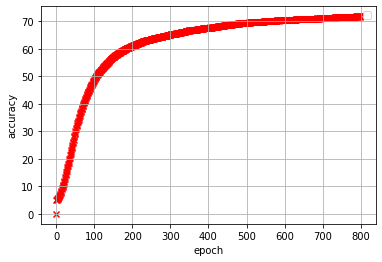

In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(len(batch_train_accs)), batch_train_accs, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()